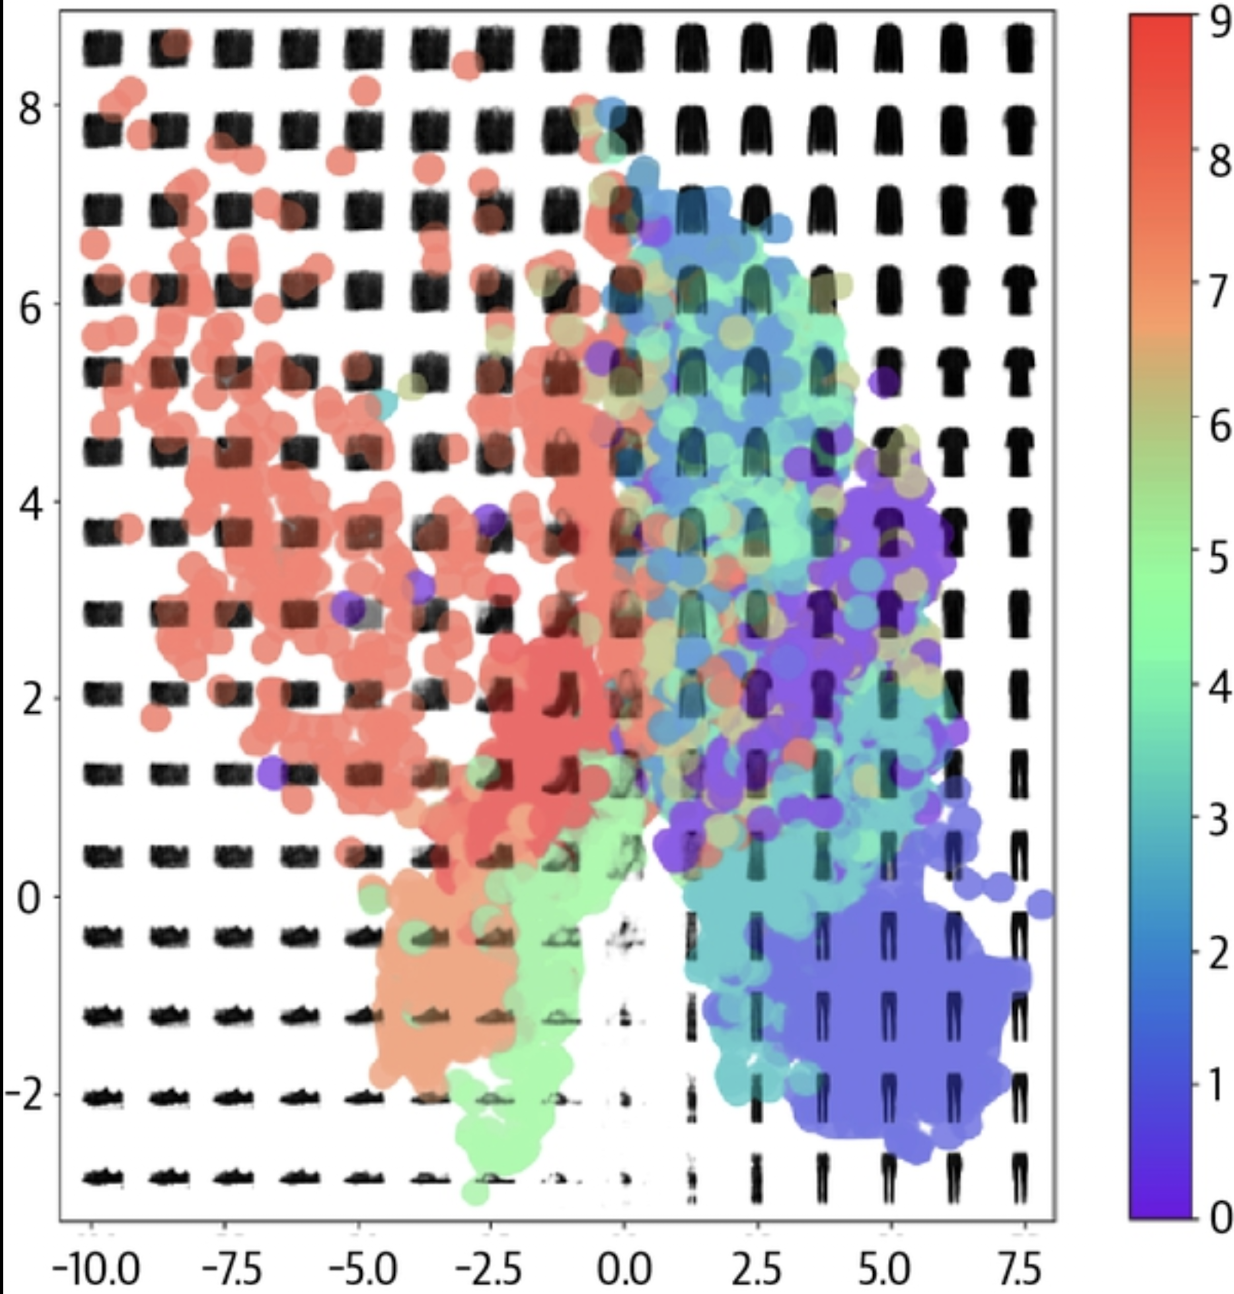

In [147]:
"""
From the last section ch_3_autoencoder, we built an autoencoder.

The issue with the autoencoder is that the latent space (all the possible encoder outputs / embeddings) doesn't produce everything in the training set.

Some of the items (image) have no associated encoding.

VAEs fix this issue with autoencoders by ensuring the entire latent space covers the training set. Instead of 1 point -> 1 image. It sorta looks like expanding out the latent space to fill the training set (will show later)

References:
- https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/9b1048dbe0d698b486ed16d529cf16fcd3aea29d/notebooks/03_vae/02_vae_fashion/vae_fashion.ipynb#L4
"""
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm
import os

# Q: What happens if we feed one of the images in the blank space into the autoencoder (not variational autoencoder), do we still get something back? or no?

Image(filename='images/autoencoder_clothing_latent_space_overlay.png', width=500)

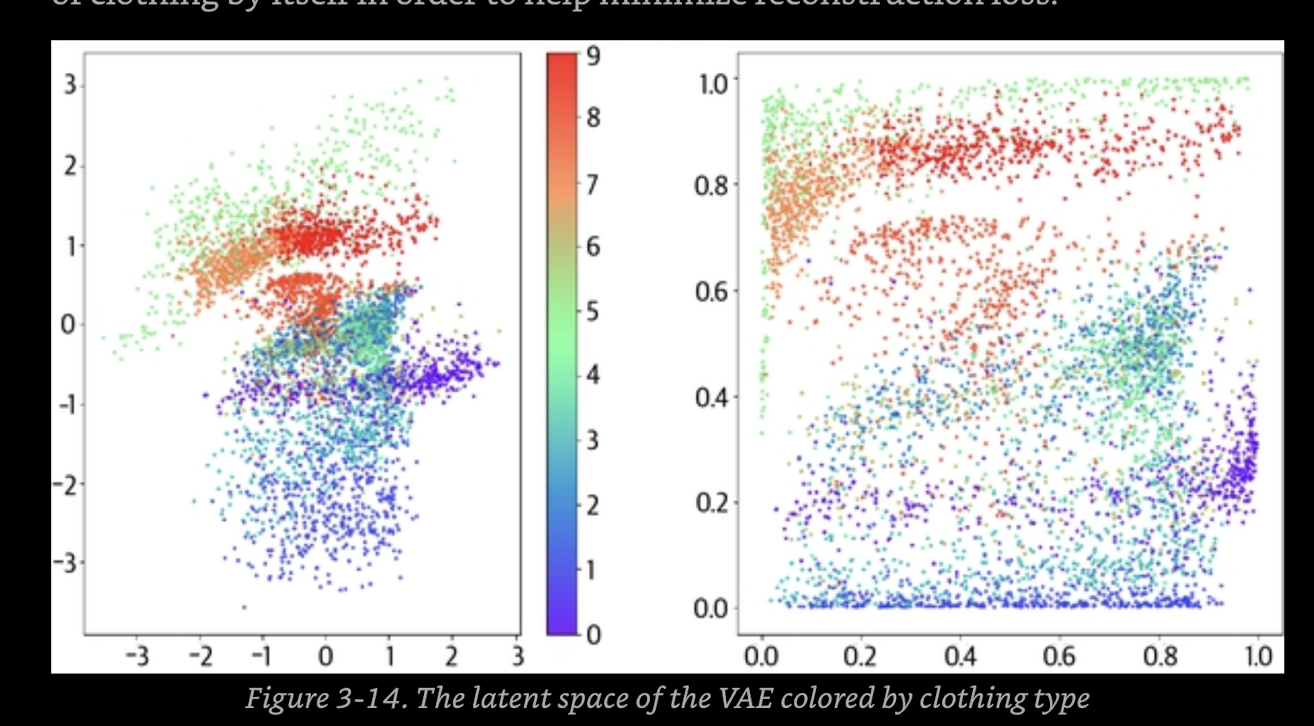

In [148]:
Image(filename='images/variational_autoencoder_clothing_latent_space.png', width=500)

In [149]:
# Load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [150]:
# Preprocess the data

def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)

    # Q: what does this do?
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [151]:
# Params, some are not used (did not fix fyi)
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

In [152]:
# Q: even though sampling is a neural network subclass, does it actually have neurons inside of itself?

# Q: if sampling has neurons then what exactly are we doing with def call here?
class Sampling(layers.Layer):
    def call(self, inputs):
        # Q: whats z_mean and z_log_var?
        # A: so instead of a 2D point that is given back like in autoencoders, it gives back z_mean and z_log_var
        #    see the screenshot below to see how they are used - you can use z_mean and z_log_var to remake the distribution function

        # Q: what exact *is* the distribution function?
        # A: it's an exponential function like y = 2^x

        # Q: is there a difference between a "gaussian" distribuition function and a "normal" distribution function?
        # A: same thing, two names

        # Q: the distribution function just looks like a curved line aka y = x^2 are they related at all? if so, why use z_mean and z_log_var instead of defining the function y = ax^2 + bx + c?
        # A: they are both curves but a normal distribution is a exponential function (y = 2^x) and not a polynomial function (y = x^2)
        #     see the screenshot below to see how they are different when graphed
        #     see screenshot below for the exact formula for the exponential function that creates the guassian distribution function
        z_mean, z_log_var = inputs

        # Q: what is tf.shape doing here? 
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]

        # Q: what exactly are we doing to get epsilon here?
        epsilon = K.random_normal(shape=(batch, dim))

        # Q: why exactly do we use this formula to produce the encoding output? what's special about this formula?
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

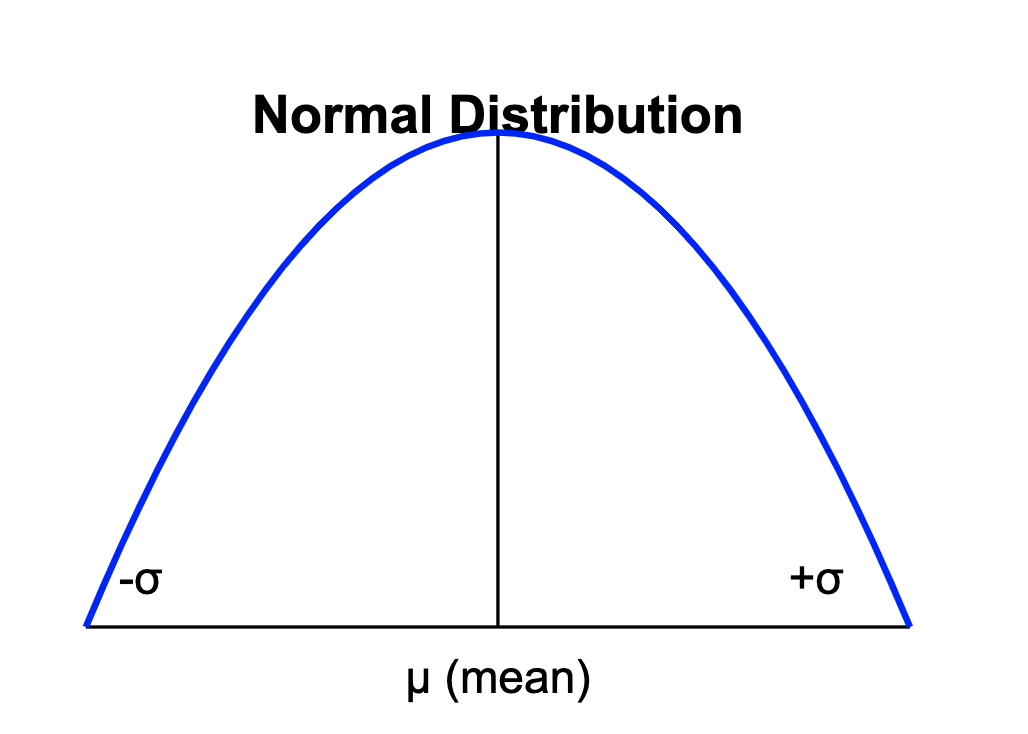

In [159]:
Image(filename='images/vae_distribution_params.png', width=500)

In [153]:
# Q: what are the key changes here to make a variational autoencoder from an autoencoder?
# A: output of encoding isn't a 2D point (in the latent space) but a z_mean and z_log_var
#    to produce the z_mean and z_log_var, 2 dense layers are used that 

encoder_input = layers.Input(
    shape=(32, 32, 1), name="encoder_input"
) # comparable

# Q: explain what (3, 3) is again

x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
) # comparable
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)

shape_before_flattening = K.int_shape(x)[1:] # for decoder, comparable

x = layers.Flatten()(x)

# Q: why is determining the z_mean and the z_log_var (of the distribution function) each a layer and not a value? 
#    or why not just use some simply functions to describe the point/s in space? instead of using a layer of neurons (dense layer) to do it?

# Q: what exactly *is* the output of Sampling() here?
# A: the output of Sampling is a 2D point in the latent space similar to an autoencoder, except now it changes a bit on each run since its a 
#    a "random" point in the distribution function

# Q: does the normal distribution cause some points to appear more often than others?

# Q: what does the output of the z_mean and z_log_var look like from these dense layers? how many neurons are in the dense layer?

# this is where it is different froma traditional autoencoder, this makes it a variational autoencoder
z_mean = layers.Dense(2, name="z_mean")(x) 
z_log_var = layers.Dense(2, name="z_log_var")(x)

# Q: if the dense layers above already make the z_mean and z_log_var for the distribution function what is Sampling doing?
z = Sampling()([z_mean, z_log_var]) 

# Q: what does the input of [z_mean, z_log_var, z] represent? why are we inputing two dense layers and a sampling layer 

# Q: what does the 16, 16; 8, 8; and 4, 4; mean in the conv2d layers?

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 8, 8, 64)  │     18,496 │ conv2d_68[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, 4, 4, 128) │     73,856 │ conv2d_69[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_21          │ (None, 2048)      │          0 │ conv2d_70[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_13         │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [154]:
# Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")

# Q: what does np.prod do here?

x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)

# summary part is at least comparable did not check above decoder code
decoder.summary()

Model: "functional_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_16 (Reshape)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_48             │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_49             │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_50             │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [155]:
# Q: does tensorflow have its on VAE model class?

class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    # Q: is call similar to inference? or is it different?

    # Q: whats the data structure of "inputs"?
    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        # Q: whats gradient tape?
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)

            # Q: why are there several types of loss/error?
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [156]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [157]:
# Create a model save checkpoint
# model_checkpoint_callback = callbacks.ModelCheckpoint(
#     filepath="./checkpoint",
#     save_weights_only=False,
#     save_freq="epoch",
#     monitor="loss",
#     mode="min",
#     save_best_only=True,
#     verbose=0,
# )
# tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [158]:
vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    # callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - kl_loss: 3.3632 - reconstruction_loss: 202.4729 - total_loss: 205.8361 - val_kl_loss: 4.9305 - val_loss: 144.5266 - val_reconstruction_loss: 139.5960
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - kl_loss: 4.8526 - reconstruction_loss: 133.3581 - total_loss: 138.2107 - val_kl_loss: 5.0633 - val_loss: 141.0793 - val_reconstruction_loss: 136.0159
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 27s 46ms/step - kl_loss: 4.8578 - reconstruction_loss: 131.5940 - total_loss: 136.4517 - val_kl_loss: 4.9149 - val_loss: 138.8664 - val_reconstruction_loss: 133.9515
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - kl_loss: 4.9644 - reconstruction_loss: 129.9957 - total_loss: 134.9601 - val_kl_loss: 5.0637 - val_loss: 137.5817 - val_reconstruction_loss: 132.5180
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step - kl_loss: 5.0559 - reconstruction_loss: 128.6149 - total_loss: 133.6708 - val_kl_loss: 5.1682 - val_loss: 136.5697 - val_recon